### Grid Searching Decision Trees

This try-it focuses on performing a grid search with a `DecisionTreeClassifier`.  As mentioned in the lectures, the grid search for a tree model can get large very easily. In addition to using `GridSearchCV`, scikitlearn implements additional tools that can save energy and offer alternatives to the brute force exhaustive search.  Below, you will compare the performance of some of these alternatives and discuss the time these searches take.  Note that this will be in large part determined by your personal computing power however the relative speed of the searches should be consistent.

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_halving_search_cv
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, HalvingGridSearchCV, HalvingRandomSearchCV

In [140]:
data = pd.read_csv('data/Whickham.txt')

data.outcome = data.outcome.map({'Alive':1, 'Dead':0})
data.smoker = data.smoker.map({'Yes':1, 'No':0})

X = data[['smoker', 'age']]
y = data['outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2)

### Comparing Grid Searches

Below, explore the four grid search options using the same parameter selections for the `DecisionTreeClassifier`. All of the grid searching tools have a `.cv_results_` attribute after fitting that contains information after fitting including time.  Use this to compare the time of each search and discuss what you believe the "best" approach to identifying the hyperparameters of the model are between:

- `GridSearchCV`
- `RandomizedSearchCV`
- `HalvingGridSearchCV`
- `HalvingRandomSearchCV`

Share your results in a plot comparing the different times for searching across the different parameters as well as the score of the different estimators that resulted from the grid search.  

In [141]:
params = {'max_depth': range(1,12),
          'min_samples_split': np.linspace(0.01,0.05,5),
          'criterion': ['gini','entropy'],
          'min_samples_leaf': np.logspace(-3,-2,5)
         }

score = pd.DataFrame({}, columns = ['BestClf', 'AvgTime', 'StdTime', 'AvgScore', 'StdScore', 'NRuns'])

for search_algo in [GridSearchCV, RandomizedSearchCV, HalvingGridSearchCV, HalvingRandomSearchCV]:

    model = search_algo(DecisionTreeClassifier(), params)

    model.fit(X_train,y_train)

    NRuns = len(model.cv_results_['mean_fit_time'])
    results = pd.DataFrame(model.cv_results_)

    score = score.append({'BestClf': model.best_estimator_, \
        'AvgTime': results['mean_fit_time'], 'StdTime': results['std_fit_time'], 
        'AvgScore': results['mean_test_score'], 'StdScore': results['std_test_score'],
        'NRuns': NRuns,\
                }, ignore_index = True)

    #print(results['mean_score_time'])

In [142]:
score

,BestClf,AvgTime,StdTime,AvgScore,StdScore,NRuns
0,"DecisionTreeClassifier(max_depth=2, min_sample...",0 0.004384 1 0.002210 2 0.00292...,0 0.003145 1 0.000243 2 0.00134...,0 0.842058 1 0.842058 2 0.84205...,0 0.019583 1 0.019583 2 0.01958...,550
1,"DecisionTreeClassifier(criterion='entropy', ma...",0 0.002936 1 0.002914 2 0.002674 3 ...,0 0.000795 1 0.000973 2 0.000914 3 ...,0 0.839210 1 0.825904 2 0.830666 3 ...,0 0.015947 1 0.014920 2 0.018404 3 ...,10
2,"DecisionTreeClassifier(max_depth=2, min_sample...",0 0.002349 1 0.002140 2 0.00235...,0 0.000594 1 0.000293 2 0.00060...,0 0.750000 1 0.750000 2 0.75000...,0 0.247207 1 0.247207 2 0.24720...,817
3,"DecisionTreeClassifier(max_depth=1, min_sample...",0 0.002366 1 0.001813 2 0.001846 3...,0 0.000581 1 0.000321 2 0.000469 3...,0 0.800000 1 0.933333 2 0.733333 3...,0 0.266667 1 0.133333 2 0.388730 3...,78


Text(0.5, 0.98, 'Runtime distribution by search method')

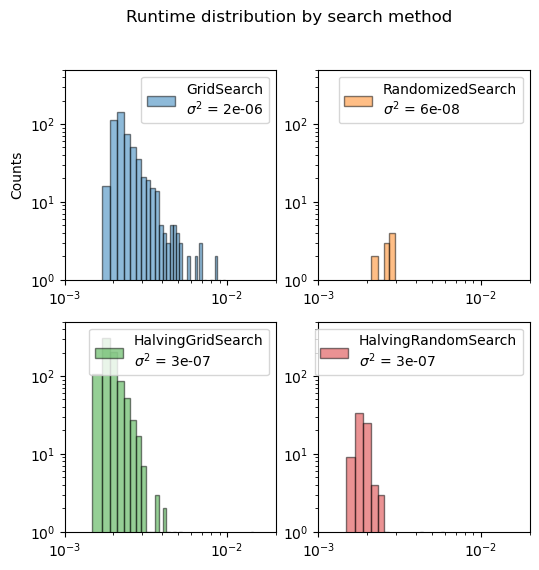

In [157]:
clf_name = ['GridSearch', 'RandomizedSearch', 'HalvingGridSearch', 'HalvingRandomSearch']

fig, axes = plt.subplots(2,2, figsize = (6,6))


for i in range(0,4):
    ax = axes.flatten()[i]
    ax.hist(score.iloc[i]['AvgTime'], bins = np.linspace(0, 0.02089066505432129, 100), \
         alpha = .5, edgecolor = 'black', color = 'C%s'%i, label = clf_name[i] + '\n' + r'$\sigma ^2$ = %.e'%score.iloc[i]['AvgTime'].var())

    #ax.axvline(x = score.iloc[i]['AvgTime'].var(), color = 'black', linestyle = '--', label = r'$\sigma ^2$ = %.2e'%score.iloc[i]['AvgTime'].var())
    ax.set_yscale('log')
    ax.set_xlim(1e-3, .2e-1)#.02089066505432129)
    ax.set_ylim(1e0, .5e3)
    ax.set_xscale('log')
    ax.legend()

axes.flatten()[0].set_ylabel('Counts')
fig.suptitle('Runtime distribution by search method')

Text(0.5, 0.98, 'Score distribution by search method')

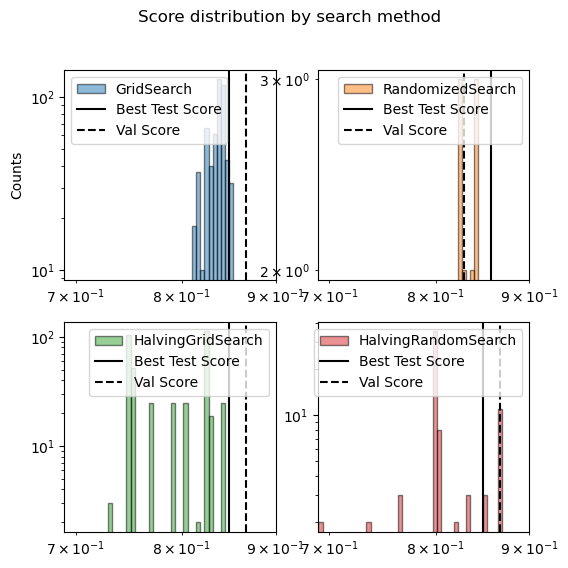

In [144]:
clf_name = ['GridSearch', 'RandomizedSearch', 'HalvingGridSearch', 'HalvingRandomSearch']

fig, axes = plt.subplots(2,2, figsize = (6,6))

for i in range(0,4):
    ax = axes.flatten()[i]
    ax.hist(score.iloc[i]['AvgScore'], bins = np.linspace(0.69, 0.9, 50), \
         alpha = .5, edgecolor = 'black', color = 'C%s'%i, label = clf_name[i])
    ax.axvline(x = score.iloc[i]['BestClf'].score(X_train, y_train), color = 'black',\
        linestyle = '-', label = 'Best Test Score')
    ax.axvline(x = score.iloc[i]['BestClf'].score(X_test, y_test), color = 'black',\
        linestyle = '--', label = 'Val Score')
    ax.set_yscale('log')
    ax.set_xlim(.69, .9)
    #ax.set_ylim(1e0, .5e3)
    ax.set_xscale('log')
    ax.legend()

axes.flatten()[0].set_ylabel('Counts')
fig.suptitle('Score distribution by search method')

Thinking abt the performance of these searching algorithms, our two elements to optimize are: time and accuracy.

Firstly, GridSearchCV results should >> other methods because it exhaustively searches every combination of the entire domain. As such, its maximum score should theoretically be the global maximum. It's odd that other algorithms outperform it. Why?

Second, we can't compare results of different algorithms 1:1 since each individual results is for a given CV and parameter setting. Ok, whatever, so what -- do we compare on maximum values? Boring way to look at it IMO. Running the same analysis multiple times is non-deterministic: both the "Randomized" searches have pseudorandom results (validation bias?) and the Decision Tree has some element of randomness when the features are splitted. That could explain the fact that some of the other searches return better results than the GridSearchCV does.

So. How do we differentiate the results from one another?

Yeah the boring solution is the way to do it I suppose. Maybe we look at maximum score vs. total time to generate said score.

I'll add a validation component to check against the high scoring estimators.

In [161]:
table = pd.DataFrame({}, columns = ['Name', 'TotalRuntime','BestTrainingScore','ValidationScore'])

for i in range(0,4):
    current = score.iloc[i]
    table = table.append( {'Name':clf_name[i], \
        'TotalRuntime': current['AvgTime'].sum(), 
        'BestTrainingScore': current['BestClf'].score(X_train, y_train),
        'ValidationScore': current['BestClf'].score(X_test, y_test)} , 
        ignore_index = True)

table.set_index('Name')

,TotalRuntime,BestTrainingScore,ValidationScore
Name,,,
GridSearch,1.495550,0.848716,0.866920
RandomizedSearch,0.026394,0.857279,0.828897
HalvingGridSearch,1.642645,0.848716,0.866920
HalvingRandomSearch,0.153899,0.848716,0.866920


In [99]:
for i in range(0,4):
    print('min:%s'%score.iloc[i]['AvgScore'].min())
    print('max:%s \n'%score.iloc[i]['AvgScore'].max())

min:0.8211795779757931
max:0.8523582852001278 

min:0.8211795779757931
max:0.8477839375380952 

min:0.7333333333333333
max:0.8833333333333332 

min:0.696969696969697
max:0.9 

